In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import einops

import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import os
import glob
from symm_loss_defs import *
from decimal import Decimal

In [20]:
#filename = "N_10000_hidden_size_100_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_4810_train_seed_6244"
#filename = "N_10000_hidden_size_100_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_2602_train_seed_3399"
#filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_0.0001_opt_Adam_data_seed_8981_train_seed_2668"
filename = "N_100000_hidden_size_300_layers_3_activation_GeLU_lr_1e-05_opt_Adam_data_seed_5927_train_seed_3643"
with open(f"./storage/{filename}.pkl","rb") as f:
    a = pickle.load(f)

In [3]:
def Lorentz_myfun(input):
        m2 = torch.einsum("... i, ij, ...j -> ...",input, torch.diag(torch.tensor([1.00,-1.00,-1.00,-1.00])).to(devicef), input)
        out = m2**2+15*m2
        return out.unsqueeze(1).to(devicef)

In [66]:
 def pred_plot_ext(analysis,data,save = False, outdir = "./",filename = ""):
        inputs = analysis.train_data.to(devicef)
        plt.clf()
        fig = {}
        for lam_val in analysis.models.keys():
            plt.clf()
            fig[lam_val] = plt.figure()
            plt.scatter(analysis.train_labels.cpu().squeeze(),analysis.models[lam_val](inputs).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} training data")
            plt.scatter(Lorentz_myfun(data).cpu().squeeze(),analysis.models[lam_val](data).detach().cpu().squeeze(),label = rf"$\lambda$ = {lam_val} new data",color = "pink",alpha = 0.2)
            plt.plot(Lorentz_myfun(data).cpu().squeeze(),Lorentz_myfun(data).cpu().squeeze(),color = "black")
            plt.legend()
            plt.xlabel("truth")
            plt.ylabel("pred")
            err = ((Lorentz_myfun(data).cpu().squeeze()-analysis.models[lam_val](data).detach().cpu().squeeze())**2).mean()
            #err = '%.4E' % Decimal("f{err}")
            err = "{:.4e}".format(err)
            mse = analysis.train_loss_lam[lam_val][-1]
            mse = "{:.4e}".format(mse)
            symm = analysis.symm_loss_lam[lam_val][-1]
            symm = "{:.4e}".format(symm)
            text = f"lam = {lam_val}, var = {err} MSE = {mse}, symm = {symm}"
            print(text)
            text = f"var = {err}, MSE = {mse}, symm = {symm}"
            plt.text(-9, -10,text)
            
            if save==True or save=="True":
                if filename =="":
                    file = f"plot_pred_lam_{lam_val}_{analysis.filename}"
                else:
                    file = filename
                fig[lam_val].show()
                fig[lam_val].savefig(f"{outdir}/plot_pred_lam_{lam_val}_{file}_{analysis.filename}.pdf")
            plt.show()
                #plt.close(fig[lam_val])


In [5]:
def Lorentz_Trans(data,beta):
    gamma = 1/np.sqrt(1-beta**2)
    LorentzBoost = torch.tensor([[gamma, -gamma*beta,  0, 0],[-gamma*beta, gamma, 0, 0],[0,0,1,0],[0,0,0,1]],dtype = torch.float32).to(devicef)
    trans_data = torch.einsum("ij,...j-> ...i",LorentzBoost,data).to(devicef)
    return trans_data

In [6]:
def rot(data,theta):
    
    rotate = torch.tensor([[1, 0,  0, 0],[0, np.cos(theta), np.sin(theta), 0],[0,-np.sin(theta),np.cos(theta),0],[0,0,0,1]],dtype = torch.float32).to(devicef)
    trans_data = torch.einsum("ij,...j-> ...i",rotate,data).to(devicef)
    return trans_data

In [7]:
Nnew = 1000
norm = 1.5
new_data  = (torch.rand(Nnew,4)-0.5)*norm
new_data = new_data.to(devicef)

In [21]:
trans_new_data = Lorentz_Trans(data = a.train_data.to(devicef),beta = 0.6)

In [22]:
rot_data = rot(data = a.train_data.to(devicef),theta = 0.5)

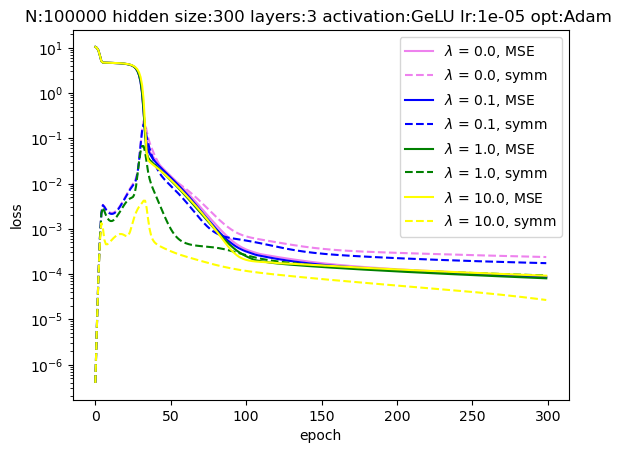

In [23]:
a.plot_losses()

In [24]:
for key in a.train_loss_lam.keys():
    print(f"lam = {key} current MSE loss = {np.min(a.train_loss_lam[key][-1])}")
    print(f"lam = {key} current sym loss = {np.min(a.symm_loss_lam[key][-1])}")
for key in a.train_loss_lam.keys():
    print(f"lam = {key} min MSE loss = {np.min(a.train_loss_lam[key])}")
    print(f"lam = {key} min sym loss = {np.min(a.symm_loss_lam[key])}")


lam = 0.0 current MSE loss = 8.878582753823139e-05
lam = 0.0 current sym loss = 0.0002377936485572718
lam = 0.1 current MSE loss = 8.509340790624264e-05
lam = 0.1 current sym loss = 0.00017425142621505074
lam = 1.0 current MSE loss = 8.057760816882365e-05
lam = 1.0 current sym loss = 9.313061862485483e-05
lam = 10.0 current MSE loss = 9.195333979732822e-05
lam = 10.0 current sym loss = 2.6713794122770197e-05
lam = 0.0 min MSE loss = 8.878582753823139e-05
lam = 0.0 min sym loss = 3.944802807609449e-07
lam = 0.1 min MSE loss = 8.509340790624264e-05
lam = 0.1 min sym loss = 3.944672863553933e-07
lam = 1.0 min MSE loss = 8.057760816882365e-05
lam = 1.0 min sym loss = 3.9435104454810243e-07
lam = 10.0 min MSE loss = 9.195333979732822e-05
lam = 10.0 min sym loss = 3.9318858298997837e-07


N =100,000

lam = 0.0, var = 1.3795e-04 MSE = 8.8786e-05, symm = 2.3779e-04


<Figure size 640x480 with 0 Axes>

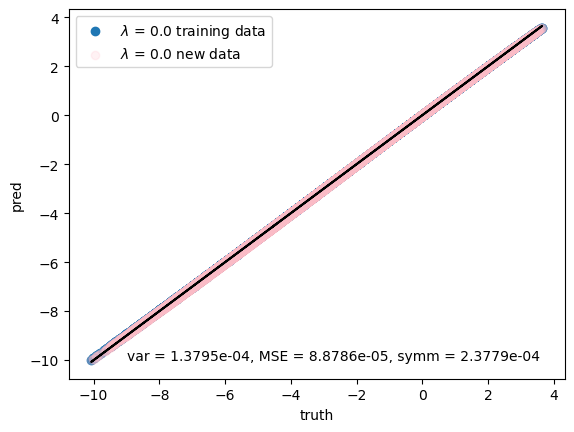

lam = 0.1, var = 1.2720e-04 MSE = 8.5093e-05, symm = 1.7425e-04


<Figure size 640x480 with 0 Axes>

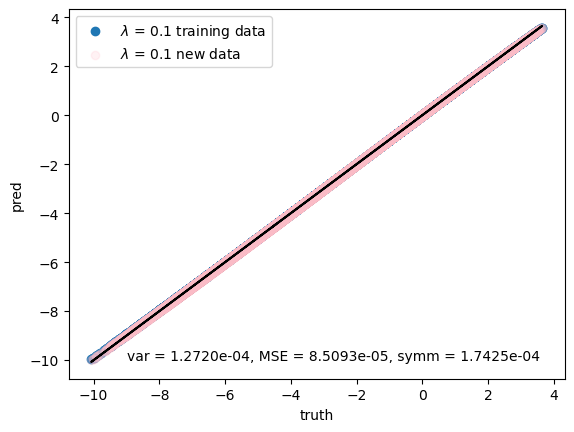

lam = 1.0, var = 8.7832e-05 MSE = 8.0578e-05, symm = 9.3131e-05


<Figure size 640x480 with 0 Axes>

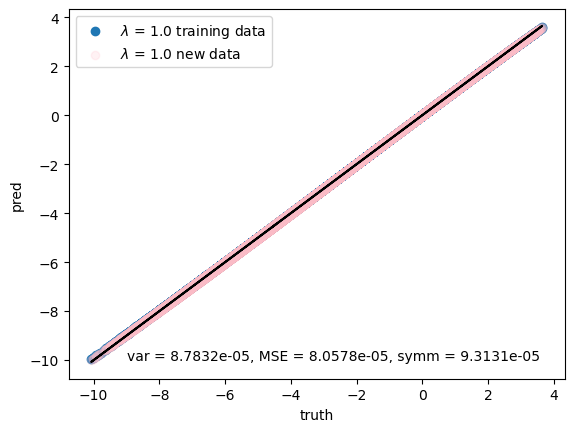

lam = 10.0, var = 8.9994e-05 MSE = 9.1953e-05, symm = 2.6714e-05


<Figure size 640x480 with 0 Axes>

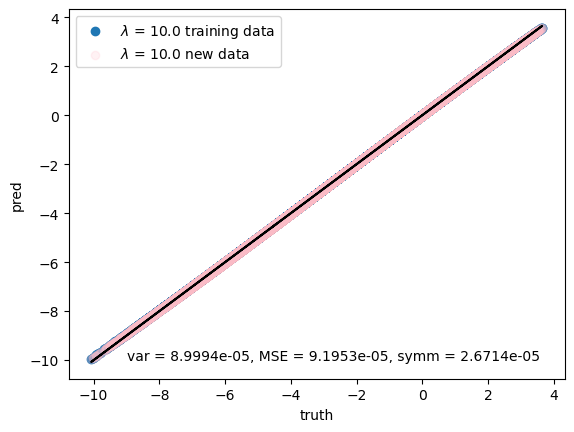

In [67]:
pred_plot_ext(a,rot_data,save = True, outdir = "./plots",filename = f"rot_0.5")

lam = 0.0, var = 1.1673e-02 MSE = 8.8786e-05, symm = 2.3779e-04


<Figure size 640x480 with 0 Axes>

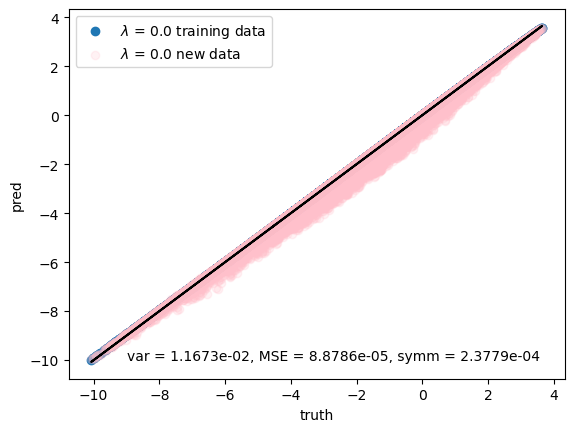

lam = 0.1, var = 6.9460e-03 MSE = 8.5093e-05, symm = 1.7425e-04


<Figure size 640x480 with 0 Axes>

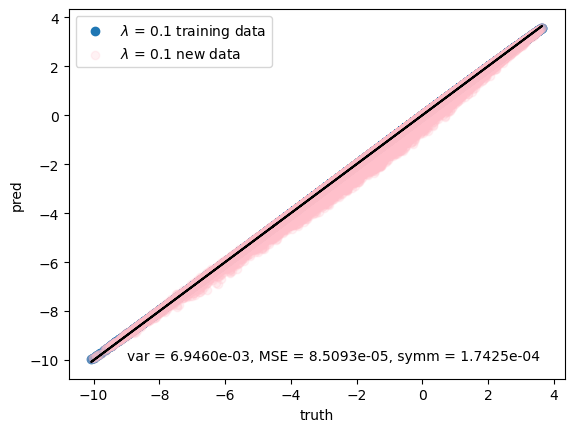

lam = 1.0, var = 2.8520e-03 MSE = 8.0578e-05, symm = 9.3131e-05


<Figure size 640x480 with 0 Axes>

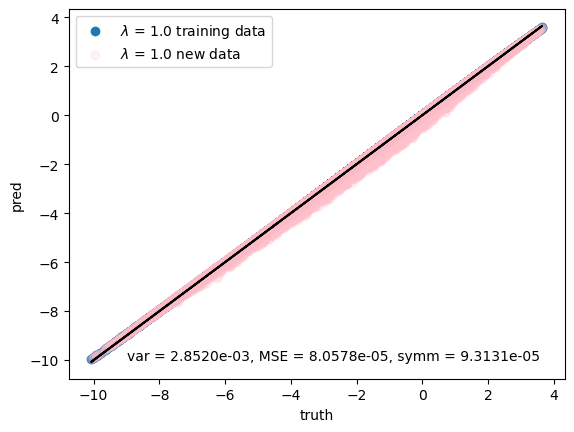

lam = 10.0, var = 1.3649e-03 MSE = 9.1953e-05, symm = 2.6714e-05


<Figure size 640x480 with 0 Axes>

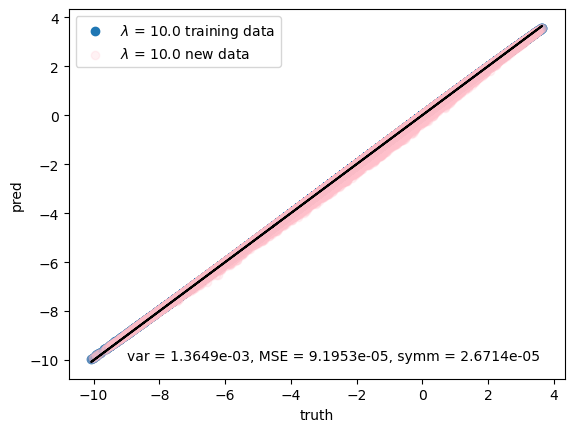

In [68]:
pred_plot_ext(a,trans_new_data,save = True, outdir = "./plots",filename = "boost_0.6")

N = 10,000

lam = 0.0, var = 0.00015094094851519912


<Figure size 640x480 with 0 Axes>

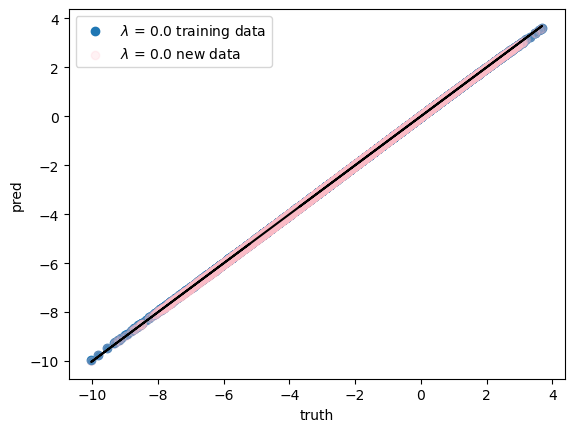

lam = 0.1, var = 0.00013319314166437835


<Figure size 640x480 with 0 Axes>

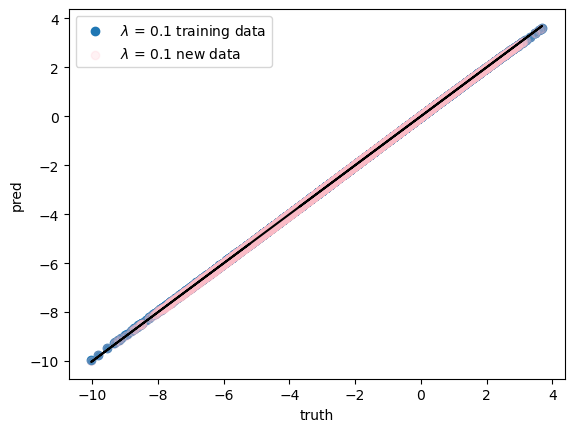

lam = 1.0, var = 0.00013627174485009164


<Figure size 640x480 with 0 Axes>

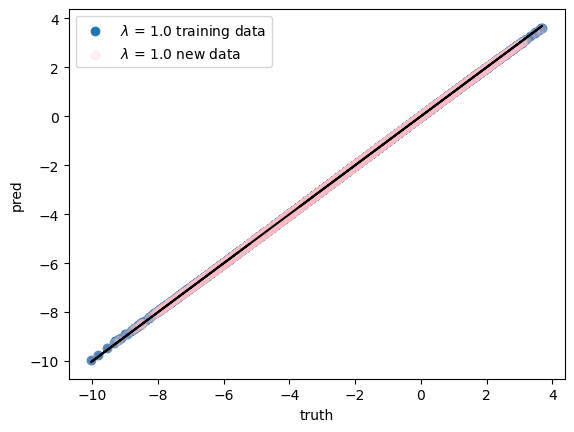

In [14]:
pred_plot_ext(a,rot_data,save = False, outdir = "./",filename = "")

lam = 0.0, var = 0.010359273292124271


<Figure size 640x480 with 0 Axes>

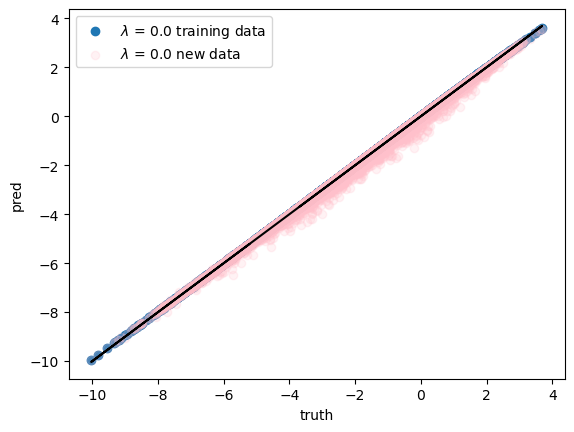

lam = 0.1, var = 0.00585052790120244


<Figure size 640x480 with 0 Axes>

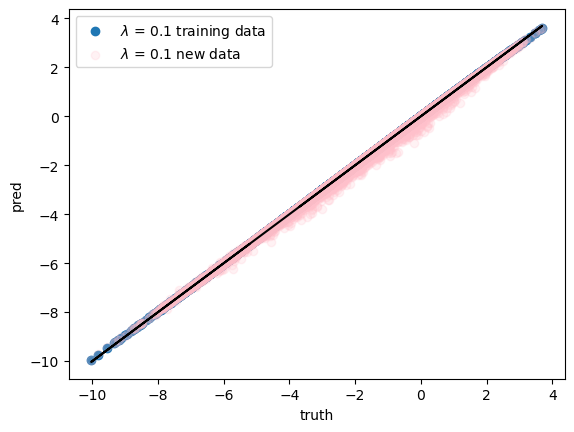

lam = 1.0, var = 0.0021061820443719625


<Figure size 640x480 with 0 Axes>

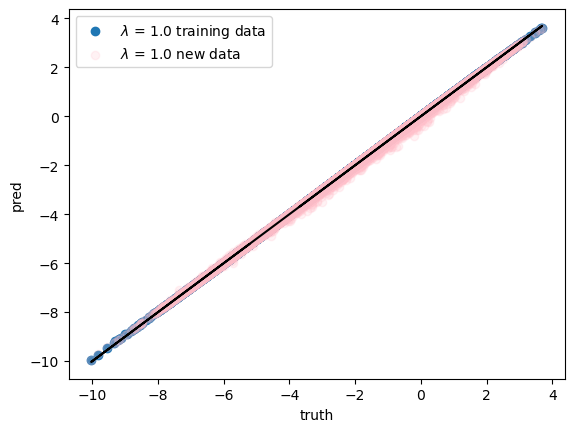

In [19]:
pred_plot_ext(a,trans_new_data,save = False, outdir = "./",filename = "")

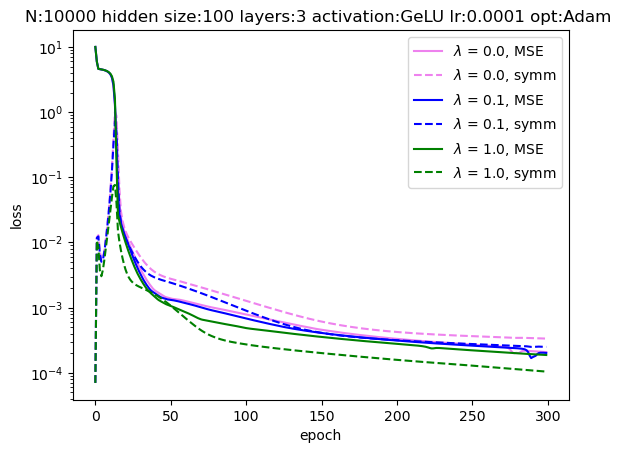

In [20]:
a.plot_losses(save = False, outdir = "./",filename = "")